Библиотеки

In [111]:
import os
import typing as tp
from itertools import product
import warnings

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import cv2
import tifffile as tiff

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Пути и прочие константы

In [2]:
IMG_PATH = '/home/jupyter-igor_busov/Seed/Hyperspectral/data/pigment/'
IMG_PATH_WHITE = IMG_PATH + 'white/'
IMG_PATH_COLORED = IMG_PATH + 'colored/'
CALIBR_WHITE_PATH_WHITE = IMG_PATH_WHITE + 'White_session_000_000_cube.tiff'
CALIBR_BLACK_PATH_WHITE = IMG_PATH_WHITE + 'Black_session_000_004_snapshot_cube.tiff'
CALIBR_WHITE_PATH_COLORED = IMG_PATH_COLORED + 'White_session_000_000_snapshot_cube.tiff'
CALIBR_BLACK_PATH_COLORED = IMG_PATH_COLORED + 'Black_session_000_001_snapshot_cube.tiff'

$\textbf{Код}$

Таблица с информацией о пигментном составе цветных изображений

In [3]:
colored_pigment = pd.read_csv(IMG_PATH + 'colored_pigment.csv')
colored_pigment.head()

,Номер образца,Название образца,меланин,Unnamed: 3,антоцианы,Unnamed: 5,пленчатый/голозерный,Гены окраски,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,NaN,чешуя,перикарп,перикарп,алейрон,NaN,NaN,имя файла,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,Rec,нет,нет,нет,нет,голозерный,нет,session_001_000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,BLP,да,да,нет,нет,пленчатый,Blp,session_001_001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,BLP-nud,нет,да,нет,нет,голозерный,Blp,session_001_002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,Bowman,нет,нет,нет,нет,пленчатый,нет,session_001_003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
needed_columns = [ 'меланин', 'Unnamed: 3', 'антоцианы', 'Unnamed: 5', 'Unnamed: 8']

In [5]:
colored_pigment = colored_pigment[needed_columns].iloc[1:].rename(columns={ 'меланин': 'melanin_scales', 
                                                                    'Unnamed: 3': 'melanin_pericarp',
                                                                    'антоцианы': 'anthocyanins_scales',
                                                                    'Unnamed: 5': 'anthocyanins_pericarp',
                                                                    'Unnamed: 8': 'file_name'
                                                                }).reset_index(drop=True)
colored_pigment = colored_pigment.replace(['нет', 'да'], [0, 1])
colored_pigment.head()

,melanin_scales,melanin_pericarp,anthocyanins_scales,anthocyanins_pericarp,file_name
0,0,0,0,0,session_001_000
1,1,1,0,0,session_001_001
2,0,1,0,0,session_001_002
3,0,0,0,0,session_001_003
4,0,0,1,0,session_001_004


In [6]:
colored_pigment['melanin'] = (colored_pigment['melanin_scales']
                              + colored_pigment['melanin_pericarp']).clip(0,1)
colored_pigment['anthocyanins'] = (colored_pigment['anthocyanins_scales']
                              + colored_pigment['anthocyanins_pericarp']).clip(0,1)
colored_pigment.head()

,melanin_scales,melanin_pericarp,anthocyanins_scales,anthocyanins_pericarp,file_name,melanin,anthocyanins
0,0,0,0,0,session_001_000,0,0
1,1,1,0,0,session_001_001,1,0
2,0,1,0,0,session_001_002,1,0
3,0,0,0,0,session_001_003,0,0
4,0,0,1,0,session_001_004,0,1


In [7]:
colored_pigment.head(11)

,melanin_scales,melanin_pericarp,anthocyanins_scales,anthocyanins_pericarp,file_name,melanin,anthocyanins
0,0,0,0,0,session_001_000,0,0
1,1,1,0,0,session_001_001,1,0
2,0,1,0,0,session_001_002,1,0
3,0,0,0,0,session_001_003,0,0
4,0,0,1,0,session_001_004,0,1
5,0,1,0,0,session_001_005,1,0
6,1,1,1,0,session_001_006,1,1
7,1,1,1,1,session_001_007,1,1
8,0,1,1,1,session_001_008,1,1
9,1,1,1,1,session_001_009,1,1


класс, описывающий гиперспектральное изображение с основными используемыми в этой работе методами 

In [8]:
class Hyper_Img:
    """
    Hyperspectral image with basic methods
    """
    
    def __init__(self, path: str, threshold_value: float = 7.5, 
                 savgol_par: tp.Tuple[int] = (9, 3)) -> None:
        self.savgol_par = savgol_par
        self._threshold_value = threshold_value
        self.path = path
        self.img = self._get_tiff()
        self.widht = self.img.shape[0]
        self.height = self.img.shape[1]
        self.pixels =  self._get_pixels()
        self.medians = self._get_medians()
        self.melanin, self.anthocyanins  = self._get_pigment()
        self.pigment: str = 'white'
        if self.melanin and self.anthocyanins:
            self.pigment = 'melanin and anthocyanins'
        elif self.melanin:
            self.pigment = 'only melanin'
        elif self.anthocyanins:
            self.pigment = 'only anthocyanins'
    
    @staticmethod
    def wave_len(x: int, step: int = 4, begin_wave_len: int = 450) -> int:
        return int((x - begin_wave_len) // step)
    
    def _get_tiff(self) -> None:
        img = tiff.imread(self.path)
        if set(IMG_PATH_WHITE.split('/')).issubset(set(self.path.split('/'))):
            bl_img = tiff.imread(CALIBR_BLACK_PATH_WHITE)
            wh_img = tiff.imread(CALIBR_WHITE_PATH_WHITE)
        else:
            bl_img = tiff.imread(CALIBR_BLACK_PATH_COLORED)
            wh_img = tiff.imread(CALIBR_WHITE_PATH_COLORED)
        new_img = np.where(bl_img > img, 0, img - bl_img)
        return new_img /(wh_img - bl_img)
    
    def _get_pigment(self) -> tp.Tuple[int, int]:
        if not set(IMG_PATH.split('/')).issubset(set(self.path.split('.')[0].split('/'))):
            raise NameError('Error in path')
            
        if np.any(np.isnan(self.medians)):
            return -3, -3
        
        if np.allclose(self.medians, np.ones(len(self.medians), dtype=float)) or \
           np.allclose(self.medians, np.zeros(len(self.medians), dtype=float)): 
            return -1, -1
        
        if set(IMG_PATH_WHITE.split('/')).issubset(set(self.path.split('/'))):
            return 0, 0
    
        name: str = '_'.join([s for s in self.path.split('/')[-1].split('_')
                        if s != 'snapshot' and s != 'cube.tiff' ])
            
        if name not in np.unique(colored_pigment.file_name):
            return -2, -2
        
        return colored_pigment[colored_pigment.file_name == name].melanin.iloc[0],\
                            colored_pigment[colored_pigment.file_name == name].anthocyanins.iloc[0]
        
    def _get_pixels(self) -> tp.List[tp.Tuple[int, int]]:
        return [(x, y) for x, y in product(range(self.widht), range(self.height)) 
                if self.threshold_bgr[x,y] != 0]
    
    def _get_medians(self) -> np.array:
        medians: tp.List[float] = list()
        for i in range(self.img.shape[2]):
            medians.append(np.median(np.array([self.img[p[0]][p[1]][i] for p in self.pixels])))
        return savgol_filter(np.array(medians), *self.savgol_par)
 
    @property
    def bgr(self) -> np.array:
        
        #To accurately display colors, you need to choose constants
        
        im_r = self.img[:,:,Hyper_Img.wave_len(630)]
        im_g = self.img[:,:,Hyper_Img.wave_len(510)]
        im_b = self.img[:,:,Hyper_Img.wave_len(450)]
    
        im_r = (im_r / im_r.max())*255
        im_g = (im_g / im_g.max())*255
        im_b = (im_b / im_b.max())*255
    
        im_r = np.clip(im_r,0,255).astype(np.uint8)
        im_g = np.clip(im_g,0,255).astype(np.uint8)
        im_b = np.clip(im_b,0,255).astype(np.uint8)
    
        im_bgr = np.zeros((self.widht, self.height, 3), dtype = np.uint8)
        im_bgr[:,:,0] = im_b
        im_bgr[:,:,1] = im_g
        im_bgr[:,:,2] = im_r
    
        return im_bgr
    
    @property
    def threshold_bgr(self) -> np.array:
        im_black = cv2.cvtColor(self.bgr, cv2.COLOR_BGR2GRAY)
        _, im_thr = cv2.threshold(im_black, self._threshold_value, 255, cv2.THRESH_BINARY)
        return im_thr
    
    def __repr__(self) -> str:
        fig, axes = plt.subplots(1, 2)
        
        axes[0].imshow(self.bgr, cmap = 'gray')
        axes[0].set_title('rgb visualization')
        
        axes[1].imshow(self.threshold_bgr, cmap = 'gray')
        axes[1].set_title('segmentation')
        
        if self.melanin == -1:
            return 'pigment: white or black image for calibration'
        elif self.melanin < 0:
            return 'unknown'
        return f'pigment: {self.pigment}'
     

Примеры изображений (визуализация не точно передает цвета)

pigment: white or black image for calibration

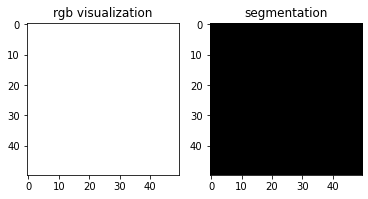

In [9]:
Hyper_Img(CALIBR_WHITE_PATH_COLORED)

pigment: only melanin

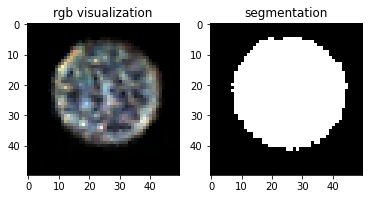

In [10]:
Hyper_Img(IMG_PATH_COLORED + 'session_001_001_snapshot_cube.tiff')

pigment: only anthocyanins

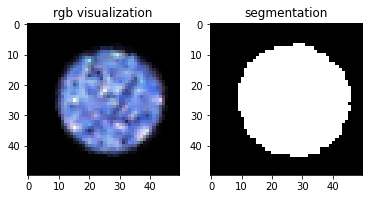

In [11]:
Hyper_Img(IMG_PATH_COLORED + 'session_001_004_snapshot_cube.tiff')

pigment: white

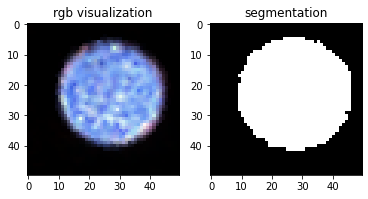

In [12]:
Hyper_Img(IMG_PATH_COLORED + 'session_001_000_snapshot_cube.tiff')

pigment: melanin and anthocyanins

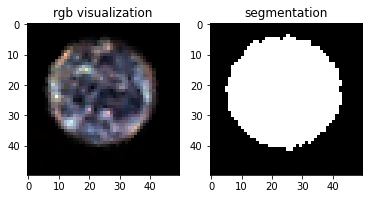

In [13]:
Hyper_Img(IMG_PATH_COLORED + 'session_001_007_snapshot_cube.tiff')

pigment: white

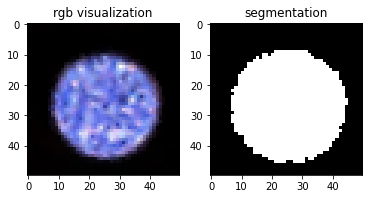

In [14]:
Hyper_Img(IMG_PATH_WHITE + 'session_001_013_snapshot_cube.tiff')

pigment: white

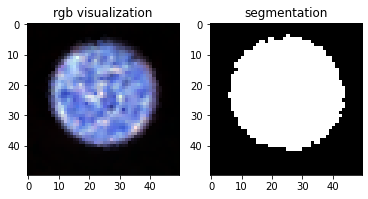

In [15]:
Hyper_Img(IMG_PATH_WHITE + 'session_001_037_snapshot_cube.tiff')

Функция, возвращающая необходимые имена в директории

In [16]:
def all_tiff_cube_img(path: str) -> tp.List[str]:
    img_names: tp.List[str] = list()
    for dirname, _, filenames in os.walk(path):
        for filename in filenames: 
            name = os.path.join(filename)
            if name.split('.')[-1] != 'tiff':
                continue
            if name.split('.')[0].split('_')[-1] != 'cube':
                continue
            img_names.append(dirname + '/' + name)
            
    return img_names 

In [17]:
warnings.simplefilter('ignore')

считываем все необходимые изображения 

In [18]:
#hyper_imgs - list with all hyperspectral images
hyper_imgs: tp.List[Hyper_Img] = [Hyper_Img(name) for name in all_tiff_cube_img(IMG_PATH)
                                   if Hyper_Img(name).melanin >= 0]        

$\textbf{Графики медиан для каждого канала}$

In [19]:
def get_all_medians(hyper_imgs: tp.List[Hyper_Img]) -> pd.DataFrame:
    """
    create DataFrame for graphics
    """
    
    x_axis: tp.List[int] = list(np.arange(0,138)*4 + 450)
    points: tp.List[tp.Tuple[float, float, int, str]] = list()
    
    for sample_number, sample in enumerate(hyper_imgs):
        
        if sample.melanin == -1:
            continue
        
        for p in zip(x_axis, sample.medians):
            points.append([p[0], p[1], sample_number, sample.pigment])
        

    return pd.DataFrame(points, columns = ['Wavelength', 'Median', 'Sample', 'Pigment'])      

In [20]:
df_all_med = get_all_medians(hyper_imgs)
df_all_med.sample(7)

,Wavelength,Median,Sample,Pigment
3547,838,0.387735,25,white
8225,782,0.075436,59,only anthocyanins
3531,774,0.467102,25,white
3815,806,0.419608,27,white
5371,958,0.052878,38,melanin and anthocyanins
9144,594,0.196750,66,only melanin
107,878,0.312238,0,white


<AxesSubplot:xlabel='Wavelength', ylabel='Median'>

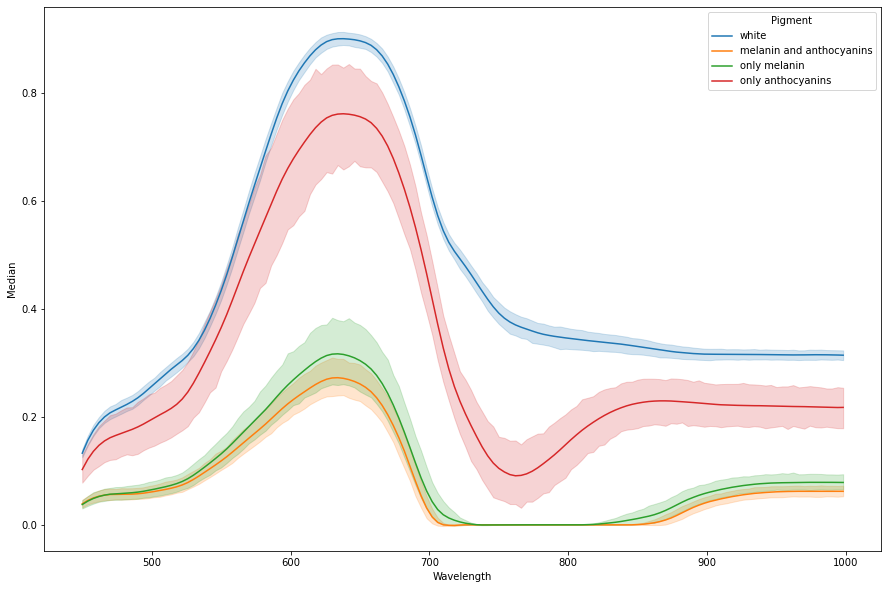

In [21]:
plt.figure(figsize=(15,10))
sns.lineplot(data = df_all_med, x = 'Wavelength', y = 'Median', hue = 'Pigment')

$\textbf{PCA}$

In [22]:
#Пайплайн
feature_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])

In [23]:
def get_med_df(hyper_imgs: tp.List[Hyper_Img]) -> pd.DataFrame:
    """
    create DataFrame for PCA
    """
        
    return pd.DataFrame([list(sample.medians) + [sample.pigment] for sample in hyper_imgs], 
                         columns = list(np.arange(0,138)*4 + 450) + ['Pigment'])    

In [24]:
df = get_med_df(hyper_imgs)
df.sample(7)

,450,454,458,462,466,470,474,478,482,486,...,966,970,974,978,982,986,990,994,998,Pigment
25,0.138604,0.166292,0.188355,0.205623,0.218926,0.229099,0.236433,0.243345,0.250288,0.257820,...,0.338450,0.338484,0.338606,0.338808,0.338908,0.339161,0.339374,0.339484,0.339424,white
45,0.038525,0.044941,0.049708,0.053042,0.055159,0.056314,0.056404,0.056291,0.056338,0.056569,...,0.063975,0.064171,0.064118,0.064106,0.063802,0.063497,0.063144,0.062766,0.062389,only melanin
24,0.125123,0.150292,0.170223,0.185703,0.197520,0.206731,0.212956,0.218754,0.224243,0.230402,...,0.326247,0.326372,0.327047,0.326163,0.326140,0.326122,0.325860,0.325161,0.323827,white
50,0.032135,0.036809,0.040437,0.043125,0.044984,0.046165,0.046395,0.046527,0.046709,0.046977,...,0.079362,0.079585,0.079727,0.079859,0.080111,0.080445,0.080652,0.080612,0.080208,melanin and anthocyanins
70,0.042948,0.050948,0.056670,0.060468,0.062697,0.063799,0.063654,0.063552,0.063590,0.063821,...,0.067802,0.067922,0.068065,0.068179,0.068205,0.068125,0.067984,0.067797,0.067577,melanin and anthocyanins
47,0.026923,0.030527,0.033772,0.036641,0.039118,0.041196,0.042596,0.043934,0.045236,0.046452,...,0.095604,0.095793,0.096017,0.096245,0.096186,0.096213,0.096242,0.096290,0.096375,only melanin
30,0.133436,0.158932,0.179744,0.196476,0.209731,0.220029,0.227419,0.234624,0.241427,0.248561,...,0.321769,0.321547,0.321517,0.321795,0.321966,0.322064,0.322053,0.321884,0.321508,white


In [25]:
X = df.drop(['Pigment'], axis = 1)
X.head()

,450,454,458,462,466,470,474,478,482,486,...,962,966,970,974,978,982,986,990,994,998
0,0.090347,0.108321,0.123391,0.135845,0.145975,0.154125,0.159635,0.164918,0.170134,0.175579,...,0.273946,0.272849,0.272059,0.271392,0.270901,0.270276,0.269762,0.269415,0.269293,0.269451
1,0.131461,0.154961,0.173581,0.188071,0.199181,0.207340,0.213903,0.220067,0.226702,0.233786,...,0.310982,0.311373,0.311499,0.311529,0.311531,0.311579,0.311293,0.311057,0.311002,0.311259
2,0.131958,0.151448,0.166479,0.177727,0.185868,0.191247,0.194933,0.198650,0.202753,0.207933,...,0.321169,0.321023,0.321085,0.321705,0.322087,0.322119,0.321809,0.321495,0.321334,0.321481
3,0.113380,0.134184,0.150814,0.163856,0.173894,0.181629,0.186704,0.191711,0.196552,0.201812,...,0.284521,0.284468,0.284835,0.285448,0.285801,0.285875,0.285714,0.285572,0.285572,0.285839
4,0.117353,0.138548,0.155029,0.167433,0.176401,0.182259,0.186108,0.189203,0.192364,0.196556,...,0.272634,0.273017,0.273216,0.273381,0.273634,0.274150,0.274480,0.274514,0.274098,0.273082


In [26]:
y = df[['Pigment']]
y.head()

,Pigment
0,white
1,white
2,white
3,white
4,white


обучение и процент дисперсии для каждой компаненты

In [27]:
X = feature_pipe.fit_transform(X)
feature_pipe['pca'].explained_variance_ratio_

array([0.96810148, 0.01908893, 0.00838639, 0.0020263 , 0.00110748])

визуализация

In [28]:
new_arr = np.array(tuple(zip(X[:,:2], y['Pigment'])))
lst_of_value = [(new_arr[i][0][0], new_arr[i][0][1], new_arr[i][1]) for i, _ in enumerate(new_arr)]
pd.DataFrame(lst_of_value, columns = ['1', '2', 'Pigment']).sample(7)

,1,2,Pigment
49,14.813766,-0.430981,only melanin
77,16.427761,-1.304710,melanin and anthocyanins
23,-12.113633,-1.410914,white
12,-9.846072,0.039408,white
22,-13.923072,-0.000369,white
27,-13.129019,-1.486404,white
7,-8.875321,0.247163,white


<AxesSubplot:xlabel='1', ylabel='2'>

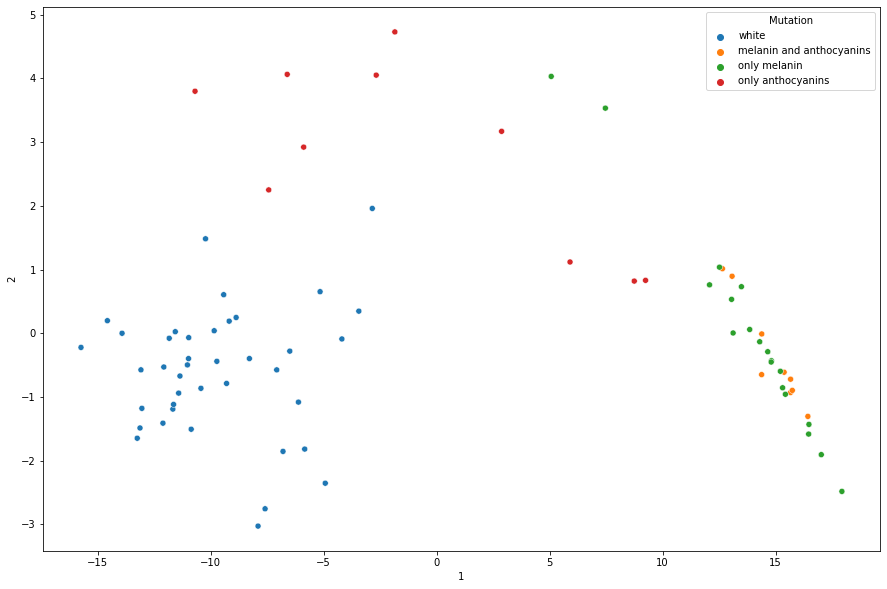

In [29]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=pd.DataFrame(lst_of_value, 
                                  columns = ['1', '2', 'Mutation']), x="1", y="2", hue="Mutation")

$\textbf{Классификация}$

In [30]:
def get_med_df_bin_classific(hyper_imgs: tp.List[Hyper_Img], class_name: str) -> pd.DataFrame:
    """
    create DataFrame for binary classification
    """
    
    def get_class(pigment: str) -> int:
        if class_name in pigment:
            return 1
        return 0
    
    return pd.DataFrame([list(sample.medians) + [get_class(sample.pigment)] for sample in hyper_imgs], 
                         columns = list(np.arange(0,138)*4 + 450) + ['Pigment'])    

Стратифицированная кросс-валидация

In [31]:
cv = StratifiedKFold(n_splits=3)

$\textbf{Классификация по наличию меланина}$

информация о данных

In [32]:
df = get_med_df_bin_classific(hyper_imgs, 'melanin')
df.sample(7)

,450,454,458,462,466,470,474,478,482,486,...,966,970,974,978,982,986,990,994,998,Pigment
63,0.012720,0.014500,0.016044,0.017354,0.018430,0.019358,0.019835,0.020141,0.020366,0.020513,...,0.033743,0.033698,0.033473,0.033559,0.033637,0.033751,0.033781,0.033660,0.033318,1
59,0.124589,0.147464,0.164967,0.177943,0.187237,0.193739,0.197897,0.201466,0.205204,0.209007,...,0.229896,0.229540,0.228901,0.228122,0.227318,0.226679,0.226532,0.227122,0.228697,0
56,0.129634,0.147845,0.162249,0.173475,0.182155,0.188605,0.193952,0.199226,0.205464,0.213467,...,0.346518,0.346275,0.345989,0.345712,0.345416,0.345299,0.345233,0.345195,0.345161,0
64,0.125388,0.152327,0.173767,0.190492,0.203291,0.212811,0.219809,0.226264,0.232501,0.238534,...,0.277465,0.276732,0.275620,0.274483,0.273710,0.273013,0.272583,0.272506,0.272868,0
57,0.052813,0.062144,0.069570,0.075322,0.079634,0.082752,0.084570,0.086090,0.087694,0.089519,...,0.160420,0.160700,0.161026,0.161321,0.161671,0.161719,0.161694,0.161640,0.161603,0
51,0.036164,0.042136,0.046767,0.050210,0.052619,0.054127,0.054716,0.055088,0.055495,0.056114,...,0.068292,0.068382,0.068530,0.068653,0.068847,0.069146,0.069393,0.069517,0.069444,1
68,0.067261,0.082089,0.093898,0.103072,0.109997,0.115151,0.118181,0.120780,0.123755,0.127034,...,0.175319,0.174742,0.174136,0.173764,0.173548,0.173555,0.173679,0.173871,0.174085,1


количество образцов каждого класса

In [33]:
df_count = df.groupby('Pigment', as_index=True).count()[[450]].rename(columns={450:'Count'}).reset_index()
df_count

,Pigment,Count
0,0,50
1,1,28


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

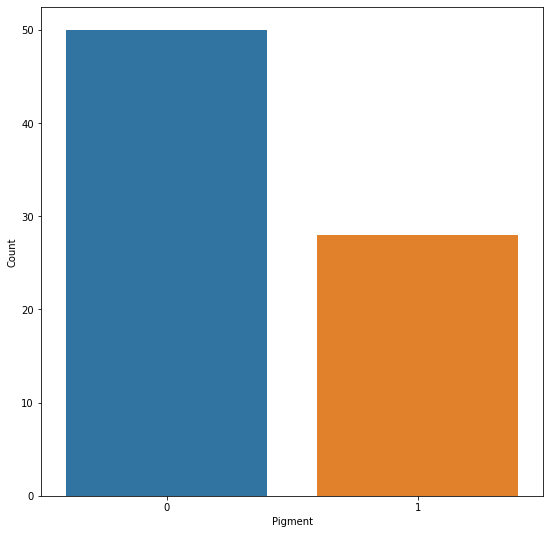

In [34]:
plt.figure(figsize=(9,9))
sns.barplot(data=df_count, x='Pigment', y='Count')

разделение выборки на обучающию и тестовую

In [35]:
X = df.drop(['Pigment'], axis = 1)
X.head()

,450,454,458,462,466,470,474,478,482,486,...,962,966,970,974,978,982,986,990,994,998
0,0.090347,0.108321,0.123391,0.135845,0.145975,0.154125,0.159635,0.164918,0.170134,0.175579,...,0.273946,0.272849,0.272059,0.271392,0.270901,0.270276,0.269762,0.269415,0.269293,0.269451
1,0.131461,0.154961,0.173581,0.188071,0.199181,0.207340,0.213903,0.220067,0.226702,0.233786,...,0.310982,0.311373,0.311499,0.311529,0.311531,0.311579,0.311293,0.311057,0.311002,0.311259
2,0.131958,0.151448,0.166479,0.177727,0.185868,0.191247,0.194933,0.198650,0.202753,0.207933,...,0.321169,0.321023,0.321085,0.321705,0.322087,0.322119,0.321809,0.321495,0.321334,0.321481
3,0.113380,0.134184,0.150814,0.163856,0.173894,0.181629,0.186704,0.191711,0.196552,0.201812,...,0.284521,0.284468,0.284835,0.285448,0.285801,0.285875,0.285714,0.285572,0.285572,0.285839
4,0.117353,0.138548,0.155029,0.167433,0.176401,0.182259,0.186108,0.189203,0.192364,0.196556,...,0.272634,0.273017,0.273216,0.273381,0.273634,0.274150,0.274480,0.274514,0.274098,0.273082


In [36]:
y = df[['Pigment']]
y.head()

,Pigment
0,0
1,0
2,0
3,0
4,0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [38]:
test_count = y_test.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
test_count

,Pigment,Count
0,0,10
1,1,6


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

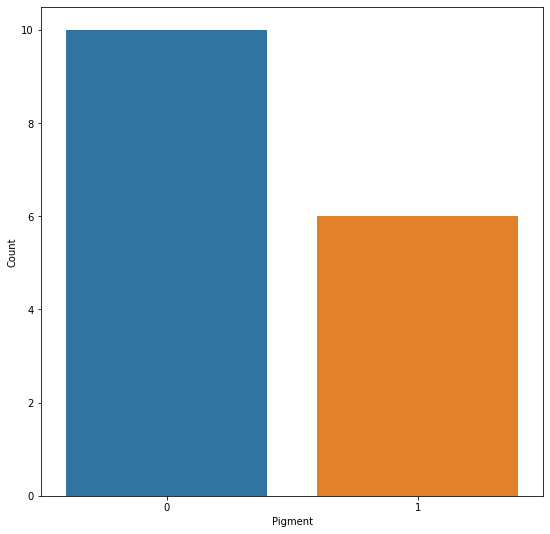

In [39]:
plt.figure(figsize=(9,9))
sns.barplot(data=test_count, x='Pigment', y='Count')

In [40]:
train_count = y_train.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
train_count

,Pigment,Count
0,0,40
1,1,22


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

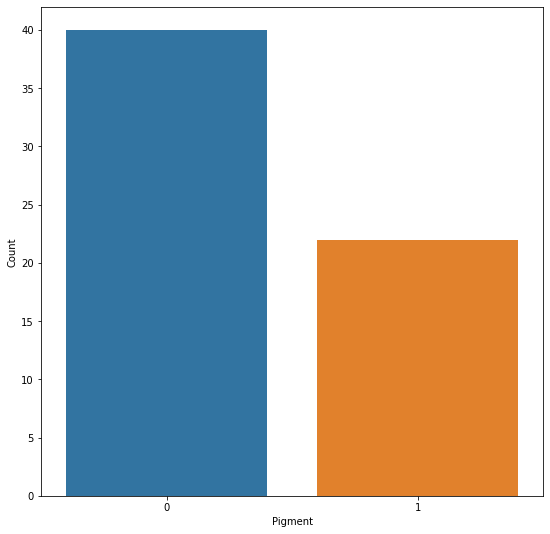

In [41]:
plt.figure(figsize=(9,9))
sns.barplot(data=train_count, x='Pigment', y='Count')

Логистическая регрессия

In [42]:
logistic_regr_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('logistic_regr', LogisticRegressionCV(cv=cv))])

In [43]:
X_train = logistic_regr_pipe['feature'].fit_transform(X_train)
X_test = logistic_regr_pipe['feature'].transform(X_test)

In [44]:
logistic_regr_pipe['logistic_regr'].fit(X_train, y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False))

In [45]:
logistic_regr_pipe['logistic_regr'].intercept_

array([-4.32209475])

Random Forest

In [46]:
parameters_random_forest = { 'max_depth':[2, 7], 'min_samples_split': [1, 5], 
                            'min_samples_leaf': [1, 5]}

In [47]:
clf_forest = GridSearchCV(RandomForestClassifier(n_estimators=150), parameters_random_forest, cv=cv)
clf_forest.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=150),
             param_grid={'max_depth': [2, 7], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [1, 5]})

In [49]:
clf_forest.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [50]:
random_forest_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('random_forest', clf_forest.best_estimator_)])

Градиентный бустинг

In [51]:
parameters_boosting = { 'learning_rate':np.power(2, np.arange(10))}

In [52]:
clf_boosting = GridSearchCV(GradientBoostingClassifier(n_estimators=150), parameters_boosting, cv=cv)
clf_boosting.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(n_estimators=150),
             param_grid={'learning_rate': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])})

In [54]:
clf_boosting.best_params_

{'learning_rate': 1}

In [55]:
gradient_boosting_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('gradient_boosting', clf_boosting.best_estimator_)])

Результаты

таблица с результатами моделей по основным метрикам

In [56]:
def get_metrics(models: tp.List[sklearn.base.BaseEstimator], models_name: tp.List[str],
                X: np.array, y: np.array) -> pd.DataFrame:
    y_predicts = [model.predict(X) for model in models]
    accuracy: tp.List[float] = [accuracy_score(y, y_predict) for y_predict in y_predicts]
    f1: tp.List[float] = [f1_score(y, y_predict) for y_predict in y_predicts]
    precision: tp.List[float] = [precision_score(y, y_predict) for y_predict in y_predicts]
    recall: tp.List[float] = [recall_score(y, y_predict) for y_predict in y_predicts]
    return pd.DataFrame(zip(models_name, accuracy, f1, precision, recall), 
                        columns = ['model', 'accuracy', 'f1', 'precision', 'recall'])

Результаты на тренеровочной выборки

In [57]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_train, y_train)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,1.000000,1.000000,1.0,1.000000
1,Random Forest,0.983871,0.976744,1.0,0.954545
2,Градиентный бустинг,1.000000,1.000000,1.0,1.000000


Результаты на тестовой выборки

In [58]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_test, y_test)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,0.9375,0.909091,1.0,0.833333
1,Random Forest,0.9375,0.909091,1.0,0.833333
2,Градиентный бустинг,0.9375,0.909091,1.0,0.833333


$\textbf{Классификация по наличию антоцианов}$

In [59]:
df = get_med_df_bin_classific(hyper_imgs, 'anthocyanins')
df.sample(7)

,450,454,458,462,466,470,474,478,482,486,...,966,970,974,978,982,986,990,994,998,Pigment
24,0.125123,0.150292,0.170223,0.185703,0.197520,0.206731,0.212956,0.218754,0.224243,0.230402,...,0.326247,0.326372,0.327047,0.326163,0.326140,0.326122,0.325860,0.325161,0.323827,0
19,0.107914,0.126384,0.140881,0.152011,0.160380,0.166625,0.170679,0.174803,0.179435,0.184801,...,0.251502,0.251825,0.251825,0.251502,0.250856,0.249863,0.249238,0.249359,0.250603,0
64,0.125388,0.152327,0.173767,0.190492,0.203291,0.212811,0.219809,0.226264,0.232501,0.238534,...,0.277465,0.276732,0.275620,0.274483,0.273710,0.273013,0.272583,0.272506,0.272868,1
22,0.175821,0.207743,0.231502,0.248616,0.260604,0.269463,0.275830,0.281453,0.287221,0.293355,...,0.354019,0.353255,0.352682,0.352326,0.352248,0.351814,0.351428,0.351168,0.351110,0
6,0.143762,0.170550,0.191274,0.206941,0.218557,0.227309,0.233586,0.239131,0.245009,0.250859,...,0.330364,0.331570,0.333109,0.333647,0.333134,0.331657,0.330072,0.328827,0.328368,0
62,0.035914,0.043077,0.048647,0.052806,0.055737,0.057630,0.058380,0.058959,0.059459,0.059938,...,0.081182,0.081351,0.081537,0.081900,0.082067,0.082116,0.081967,0.081569,0.080869,0
2,0.131958,0.151448,0.166479,0.177727,0.185868,0.191247,0.194933,0.198650,0.202753,0.207933,...,0.321023,0.321085,0.321705,0.322087,0.322119,0.321809,0.321495,0.321334,0.321481,0


количество образцов каждого класса

In [60]:
df_count = df.groupby('Pigment', as_index=True).count()[[450]].rename(columns={450:'Count'}).reset_index()
df_count

,Pigment,Count
0,0,59
1,1,19


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

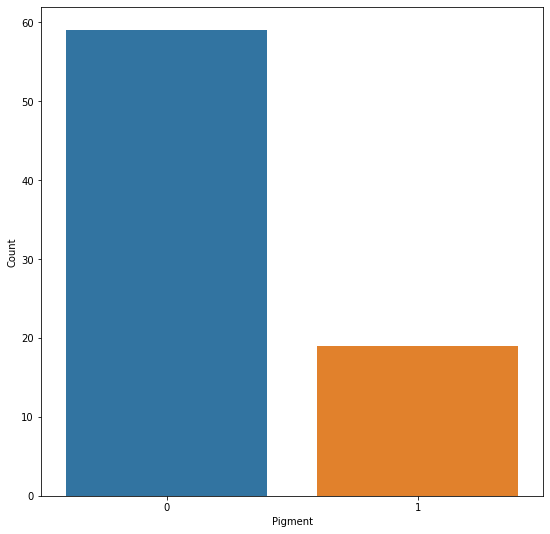

In [61]:
plt.figure(figsize=(9,9))
sns.barplot(data=df_count, x='Pigment', y='Count')

разделение выборки на обучающию и тестовую

In [62]:
X = df.drop(['Pigment'], axis = 1)
X.head()

,450,454,458,462,466,470,474,478,482,486,...,962,966,970,974,978,982,986,990,994,998
0,0.090347,0.108321,0.123391,0.135845,0.145975,0.154125,0.159635,0.164918,0.170134,0.175579,...,0.273946,0.272849,0.272059,0.271392,0.270901,0.270276,0.269762,0.269415,0.269293,0.269451
1,0.131461,0.154961,0.173581,0.188071,0.199181,0.207340,0.213903,0.220067,0.226702,0.233786,...,0.310982,0.311373,0.311499,0.311529,0.311531,0.311579,0.311293,0.311057,0.311002,0.311259
2,0.131958,0.151448,0.166479,0.177727,0.185868,0.191247,0.194933,0.198650,0.202753,0.207933,...,0.321169,0.321023,0.321085,0.321705,0.322087,0.322119,0.321809,0.321495,0.321334,0.321481
3,0.113380,0.134184,0.150814,0.163856,0.173894,0.181629,0.186704,0.191711,0.196552,0.201812,...,0.284521,0.284468,0.284835,0.285448,0.285801,0.285875,0.285714,0.285572,0.285572,0.285839
4,0.117353,0.138548,0.155029,0.167433,0.176401,0.182259,0.186108,0.189203,0.192364,0.196556,...,0.272634,0.273017,0.273216,0.273381,0.273634,0.274150,0.274480,0.274514,0.274098,0.273082


In [63]:
y = df[['Pigment']]
y.head()

,Pigment
0,0
1,0
2,0
3,0
4,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [65]:
test_count = y_test.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
test_count

,Pigment,Count
0,0,12
1,1,4


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

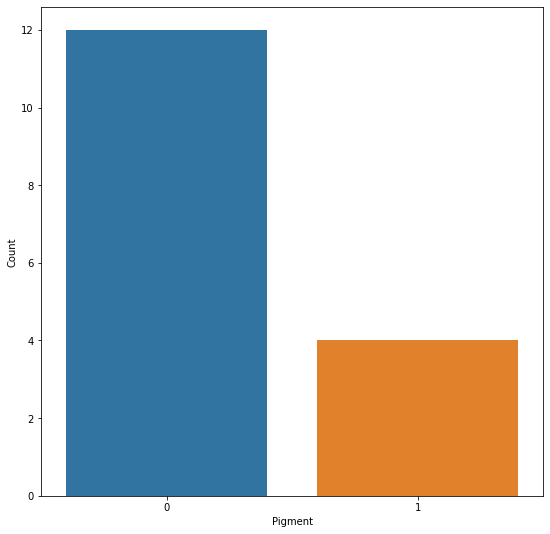

In [66]:
plt.figure(figsize=(9,9))
sns.barplot(data=test_count, x='Pigment', y='Count')

In [67]:
train_count = y_train.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
train_count

,Pigment,Count
0,0,47
1,1,15


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

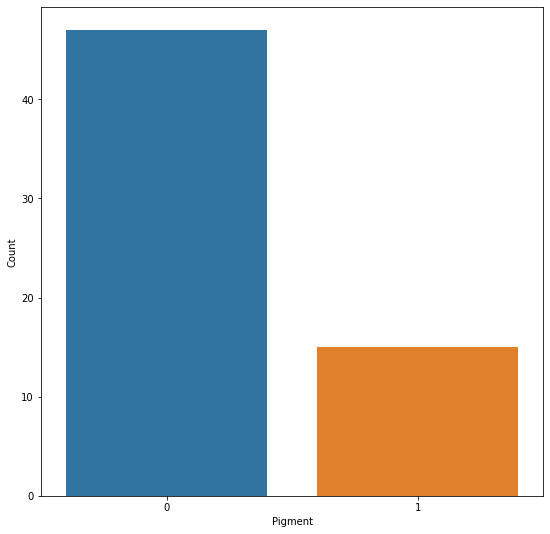

In [68]:
plt.figure(figsize=(9,9))
sns.barplot(data=train_count, x='Pigment', y='Count')

Логистическая регрессия

In [69]:
logistic_regr_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('logistic_regr', LogisticRegressionCV(cv=cv))])

In [70]:
X_train = logistic_regr_pipe['feature'].fit_transform(X_train)
X_test = logistic_regr_pipe['feature'].transform(X_test)

In [71]:
logistic_regr_pipe['logistic_regr'].fit(X_train, y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False))

In [72]:
logistic_regr_pipe['logistic_regr'].intercept_

array([-3.82464572])

Random Forest

In [73]:
parameters_random_forest = { 'max_depth':[2, 5], 'min_samples_split': [1, 5], 
                            'min_samples_leaf': [1, 5]}

In [74]:
clf_forest = GridSearchCV(RandomForestClassifier(n_estimators=150), parameters_random_forest, cv=cv)
clf_forest.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=150),
             param_grid={'max_depth': [2, 5], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [1, 5]})

In [76]:
clf_forest.best_params_

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [77]:
random_forest_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('random_forest', clf_forest.best_estimator_)])

Градиентный бустинг

In [78]:
parameters_boosting = { 'learning_rate':np.power(2, np.arange(10))}

In [79]:
clf_boosting = GridSearchCV(GradientBoostingClassifier(n_estimators=150), parameters_boosting, cv=cv)
clf_boosting.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(n_estimators=150),
             param_grid={'learning_rate': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])})

In [81]:
clf_boosting.best_params_

{'learning_rate': 2}

In [82]:
gradient_boosting_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('gradient_boosting', clf_boosting.best_estimator_)])

Результаты

Результаты на тренеровочной выборки

In [83]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_train, y_train)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,0.887097,0.758621,0.785714,0.733333
1,Random Forest,1.000000,1.000000,1.000000,1.000000
2,Градиентный бустинг,1.000000,1.000000,1.000000,1.000000


Результаты на тестовой выборки

In [84]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_test, y_test)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,0.875,0.750000,0.75,0.75
1,Random Forest,0.875,0.666667,1.00,0.50
2,Градиентный бустинг,0.750,0.333333,0.50,0.25


$\textbf{Классификация по наличию пигмента}$

информация о данных

In [85]:
df = get_med_df_bin_classific(hyper_imgs, 'white')
df.sample(7)

,450,454,458,462,466,470,474,478,482,486,...,966,970,974,978,982,986,990,994,998,Pigment
56,0.129634,0.147845,0.162249,0.173475,0.182155,0.188605,0.193952,0.199226,0.205464,0.213467,...,0.346518,0.346275,0.345989,0.345712,0.345416,0.345299,0.345233,0.345195,0.345161,1
10,0.158506,0.187828,0.209954,0.226149,0.237680,0.245846,0.251985,0.257504,0.263459,0.269049,...,0.340978,0.340336,0.340003,0.340068,0.339537,0.339158,0.338857,0.338671,0.338638,1
73,0.027155,0.031206,0.034539,0.037208,0.039263,0.040841,0.041552,0.042023,0.042601,0.043156,...,0.067069,0.067154,0.067287,0.067361,0.067595,0.067609,0.067586,0.067558,0.067558,0
45,0.038525,0.044941,0.049708,0.053042,0.055159,0.056314,0.056404,0.056291,0.056338,0.056569,...,0.063975,0.064171,0.064118,0.064106,0.063802,0.063497,0.063144,0.062766,0.062389,0
40,0.060695,0.069054,0.074664,0.078020,0.079615,0.079879,0.079389,0.078975,0.078892,0.079411,...,0.068921,0.069509,0.069836,0.070064,0.070108,0.070247,0.070358,0.070430,0.070454,0
36,0.131937,0.157689,0.178477,0.194948,0.207749,0.217225,0.224108,0.230814,0.237221,0.244302,...,0.331660,0.332017,0.332674,0.333633,0.333533,0.333333,0.333156,0.333156,0.333488,1
59,0.124589,0.147464,0.164967,0.177943,0.187237,0.193739,0.197897,0.201466,0.205204,0.209007,...,0.229896,0.229540,0.228901,0.228122,0.227318,0.226679,0.226532,0.227122,0.228697,0


количество образцов каждого класса

In [86]:
df_count = df.groupby('Pigment', as_index=True).count()[[450]].rename(columns={450:'Count'}).reset_index()
df_count

,Pigment,Count
0,0,38
1,1,40


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

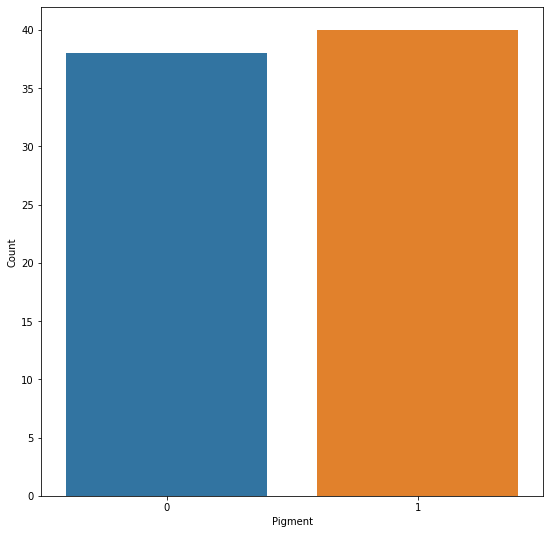

In [87]:
plt.figure(figsize=(9,9))
sns.barplot(data=df_count, x='Pigment', y='Count')

разделение выборки на обучающию и тестовую

In [88]:
X = df.drop(['Pigment'], axis = 1)
X.head()

,450,454,458,462,466,470,474,478,482,486,...,962,966,970,974,978,982,986,990,994,998
0,0.090347,0.108321,0.123391,0.135845,0.145975,0.154125,0.159635,0.164918,0.170134,0.175579,...,0.273946,0.272849,0.272059,0.271392,0.270901,0.270276,0.269762,0.269415,0.269293,0.269451
1,0.131461,0.154961,0.173581,0.188071,0.199181,0.207340,0.213903,0.220067,0.226702,0.233786,...,0.310982,0.311373,0.311499,0.311529,0.311531,0.311579,0.311293,0.311057,0.311002,0.311259
2,0.131958,0.151448,0.166479,0.177727,0.185868,0.191247,0.194933,0.198650,0.202753,0.207933,...,0.321169,0.321023,0.321085,0.321705,0.322087,0.322119,0.321809,0.321495,0.321334,0.321481
3,0.113380,0.134184,0.150814,0.163856,0.173894,0.181629,0.186704,0.191711,0.196552,0.201812,...,0.284521,0.284468,0.284835,0.285448,0.285801,0.285875,0.285714,0.285572,0.285572,0.285839
4,0.117353,0.138548,0.155029,0.167433,0.176401,0.182259,0.186108,0.189203,0.192364,0.196556,...,0.272634,0.273017,0.273216,0.273381,0.273634,0.274150,0.274480,0.274514,0.274098,0.273082


In [89]:
y = df[['Pigment']]
y.head()

,Pigment
0,1
1,1
2,1
3,1
4,1


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [91]:
test_count = y_test.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
test_count

,Pigment,Count
0,0,8
1,1,8


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

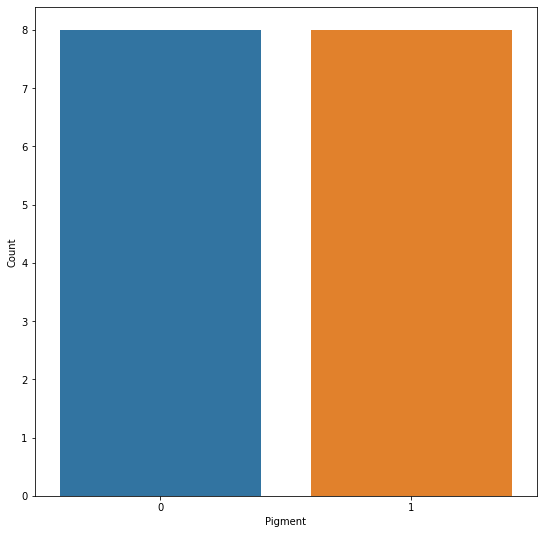

In [92]:
plt.figure(figsize=(9,9))
sns.barplot(data=test_count, x='Pigment', y='Count')

In [93]:
train_count = y_train.reset_index().groupby('Pigment').count().reset_index().rename(columns={'index':'Count'})
train_count

,Pigment,Count
0,0,30
1,1,32


<AxesSubplot:xlabel='Pigment', ylabel='Count'>

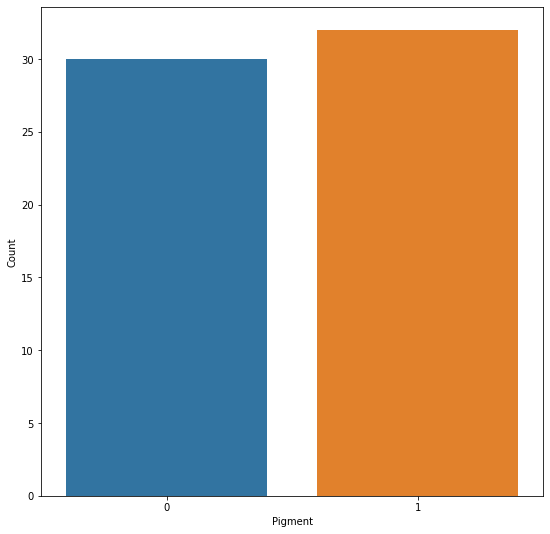

In [94]:
plt.figure(figsize=(9,9))
sns.barplot(data=train_count, x='Pigment', y='Count')

Логистическая регрессия

In [95]:
logistic_regr_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('logistic_regr', LogisticRegressionCV(cv=cv))])

In [96]:
X_train = logistic_regr_pipe['feature'].fit_transform(X_train)
X_test = logistic_regr_pipe['feature'].transform(X_test)

In [97]:
logistic_regr_pipe['logistic_regr'].fit(X_train, y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False))

In [98]:
logistic_regr_pipe['logistic_regr'].intercept_

array([1.22531569])

Random Forest

In [99]:
parameters_random_forest = { 'max_depth':[2, 7], 'min_samples_split': [1, 5], 
                            'min_samples_leaf': [1, 5]}

In [100]:
clf_forest = GridSearchCV(RandomForestClassifier(n_estimators=150), parameters_random_forest, cv=cv)
clf_forest.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=150),
             param_grid={'max_depth': [2, 7], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [1, 5]})

In [102]:
clf_forest.best_params_

{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [103]:
random_forest_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('random_forest', clf_forest.best_estimator_)])

Градиентный бустинг

In [104]:
parameters_boosting = { 'learning_rate':np.power(2, np.arange(10))}

In [105]:
clf_boosting = GridSearchCV(GradientBoostingClassifier(n_estimators=150), parameters_boosting, cv=cv)
clf_boosting.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(n_estimators=150),
             param_grid={'learning_rate': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])})

In [107]:
clf_boosting.best_params_

{'learning_rate': 1}

In [108]:
gradient_boosting_pipe = Pipeline([('feature', Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])),
                               ('gradient_boosting', clf_boosting.best_estimator_)])

Результаты

Результаты на тренеровочной выборки

In [109]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_train, y_train)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,1.0,1.0,1.0,1.0
1,Random Forest,1.0,1.0,1.0,1.0
2,Градиентный бустинг,1.0,1.0,1.0,1.0


Результаты на тестовой выборки

In [110]:
get_metrics([logistic_regr_pipe['logistic_regr'], random_forest_pipe['random_forest'], 
             gradient_boosting_pipe['gradient_boosting']], 
             ['Логистическая регрессия', 'Random Forest', 'Градиентный бустинг'], X_test, y_test)

,model,accuracy,f1,precision,recall
0,Логистическая регрессия,1.0,1.0,1.0,1.0
1,Random Forest,1.0,1.0,1.0,1.0
2,Градиентный бустинг,1.0,1.0,1.0,1.0
